# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    #x_scaled = StandardScaler().fit_transform(x.values)    
    scaler_obj = StandardScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,sema_diff,...,ssma,ssma_diff,lsma,lsma_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,direction
0,1.146322,0.000234,0.000011,-0.000009,0.000007,0.000010,0.726481,42.078708,1.146324,-1.855815e-07,...,1.146312,0.000003,1.146357,-0.000002,-0.000046,1.146361,1.146198,0.000039,-0.000124,same
1,1.146271,0.000306,0.000015,-0.000051,0.000007,0.000011,0.686985,40.722656,1.146319,-5.075611e-06,...,1.146315,0.000004,1.146353,-0.000005,-0.000037,1.146361,1.146224,0.000090,-0.000047,same
2,1.146260,0.000335,0.000007,-0.000011,0.000007,0.000012,0.597542,37.403846,1.146313,-5.639989e-06,...,1.146317,0.000002,1.146350,-0.000003,-0.000033,1.146361,1.146228,0.000101,-0.000032,same
3,1.146310,0.000254,0.000028,0.000050,0.000010,0.000012,0.881720,46.857143,1.146313,-3.143270e-07,...,1.146321,0.000004,1.146342,-0.000008,-0.000021,1.146361,1.146260,0.000052,-0.000050,same
4,1.146294,0.000307,0.000028,-0.000015,0.000010,0.000009,1.205882,54.666667,1.146311,-1.742447e-06,...,1.146319,-0.000002,1.146334,-0.000008,-0.000015,1.146361,1.146260,0.000067,-0.000035,same


In [4]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 1459266
--------------------------
same        1035732
decrease     213280
increase     210254
Name: direction, dtype: int64
--------------------------
same        0.709762
decrease    0.146156
increase    0.144082
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [6]:
model = Sequential([
    Dense(units = 256, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 512, activation='relu'),
    Dense(units = 1024, activation='relu'),
    Dense(units = 32, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5888      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 695,683
Trainable params: 695,683
Non-trainable params: 0
_________________________________________________________________


### Training

In [7]:
epoch_val         = 20
batch_size_val    = 512

verbose_val       = 2
workers_val       = -1

In [8]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/20
2281/2281 - 6s - loss: 0.2931 - accuracy: 0.8781 - val_loss: 0.2779 - val_accuracy: 0.8830
Epoch 2/20
2281/2281 - 6s - loss: 0.2723 - accuracy: 0.8854 - val_loss: 0.2751 - val_accuracy: 0.8844
Epoch 3/20
2281/2281 - 6s - loss: 0.2706 - accuracy: 0.8864 - val_loss: 0.2712 - val_accuracy: 0.8860
Epoch 4/20
2281/2281 - 6s - loss: 0.2695 - accuracy: 0.8868 - val_loss: 0.2702 - val_accuracy: 0.8868
Epoch 5/20
2281/2281 - 7s - loss: 0.2691 - accuracy: 0.8867 - val_loss: 0.2705 - val_accuracy: 0.8867
Epoch 6/20
2281/2281 - 6s - loss: 0.2685 - accuracy: 0.8871 - val_loss: 0.2712 - val_accuracy: 0.8862
Epoch 7/20
2281/2281 - 7s - loss: 0.2681 - accuracy: 0.8872 - val_loss: 0.2699 - val_accuracy: 0.8872
Epoch 8/20
2281/2281 - 7s - loss: 0.2677 - accuracy: 0.8874 - val_loss: 0.2695 - val_accuracy: 0.8872
Epoch 9/20
2281/2281 - 7s - loss: 0.2675 - accuracy: 0.8876 - val_loss: 0.2687 - val_accuracy: 0.8873
Epoch 10/20
2281/2281 - 7s - loss: 0.2671 - accuracy: 0.8879 - val_loss: 0.2696 - 

### DNN Validation

In [9]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.81      0.80      0.80     42463
    increase       0.83      0.77      0.80     42134
        same       0.91      0.93      0.92    207257

    accuracy                           0.89    291854
   macro avg       0.85      0.83      0.84    291854
weighted avg       0.89      0.89      0.89    291854



In [10]:
model.save('data/model/model.h5') 
model_new = load_model('data/model/model.h5')

### DNN Prediction

Record count : 1302389
--------------------------
same        655016
decrease    325504
increase    321869
Name: direction, dtype: int64
--------------------------
same        0.502934
decrease    0.249928
increase    0.247137
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.95      0.57      0.71    325504
    increase       0.96      0.53      0.69    321869
        same       0.69      0.97      0.81    655016

    accuracy                           0.76   1302389
   macro avg       0.86      0.69      0.73   1302389
weighted avg       0.82      0.76      0.75   1302389



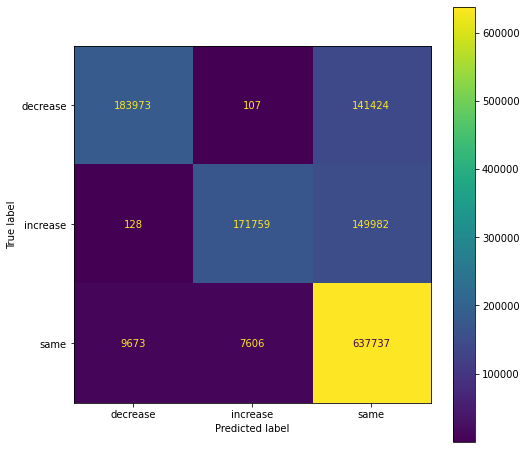

In [11]:
df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

## RF Results

%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
del live_df['predicted_direction']

model_new = load_model('data/model/model.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

predictions = model_new.predict(x_scaled)
rounded_predictions = np.argmax(predictions, axis = -1)

live_df['predictions'] = y_map[data['rounded_predictions'][0]]

live_df['predictions'].value_counts()